# Olist project : customer segmentation  
## Different clustering approach : 
The goal is to group clients that have a similar profile. The group segmentation will help the marketing company to better communicate with them, for example with personalize adds or marketing campaign for specific groups.

Here we conduct different clustering approach based on K-means on first with different choice of parameters as input 
: 
- RFM : Recency, Frequency and Monetary values
- RFM and information on localization, satisfaction and payment installments 
- All of them but clustering precede by a PCA. 

Then on the best approach we also conduct a clustering with the following algorithms : 

- Agglomerative clustering
- DBSCAN 




In [168]:
%load_ext pycodestyle_magic
%pycodestyle_on
import sys
sys.path.append('../tools/')
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
from sklearn.decomposition import PCA
from pca_fn import display_circles
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import DBSCAN 

In [169]:
clients = pd.read_csv("clients.csv", low_memory=False)

In [170]:
clients.set_index("customer_unique_id")
col = clients.columns[1:]
silhouette_score_dt = {}
davies_bouldin_score_dt = {}
col

Index(['recency_bx', 'frequency_lg', 'montant_bx'], dtype='object')

K-means interpret closeness based on euclidean distance, so need to normalize the data. 

## K-means based on RFM variables

The goal here is to know how many kernels we will initialized for K-means clustering. For that we will look at different metrics such as the silhouette coefficient, the distortion and Davies-Bouldin score : 

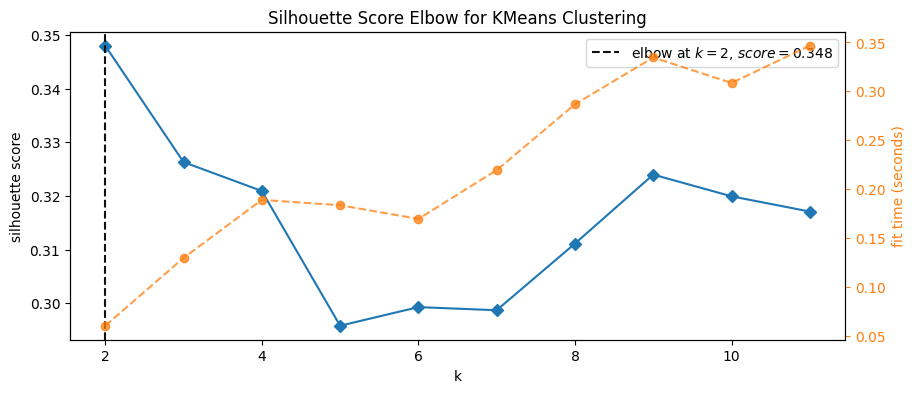

In [171]:
df = clients[col]
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12), metric='silhouette')
visualizer.fit(df)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()

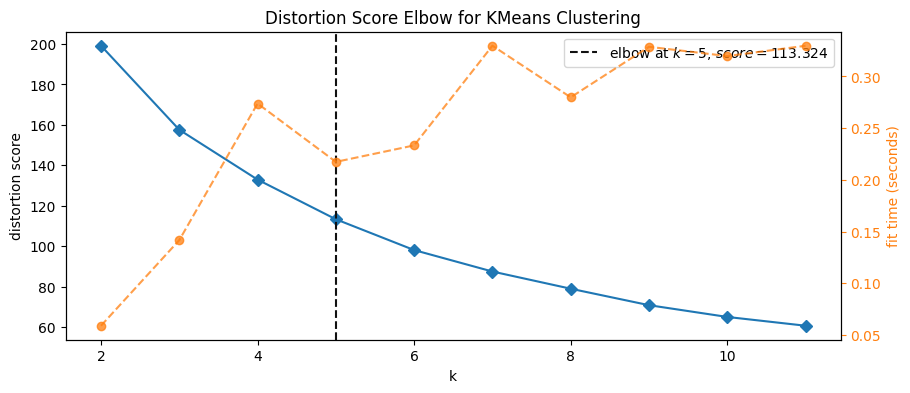

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [172]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(df)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [173]:
def run_kmeans(data, k):
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        max_iter=300,
        random_state=42)
    kmeans.fit(data)
    centroids = kmeans.cluster_centers_
    label = kmeans.labels_
    inertia = kmeans.inertia_
    silhouette_score = metrics.silhouette_score(data, label)
    return inertia, label, centroids, silhouette_score

In [174]:
df = clients[col]
labels_save = pd.DataFrame()
silhouette_score_vec = []
inertia_vec = []
davies_bouldin = []
for k in range(2, 10):
    inertia, label, centroids_df, silhouette_score = run_kmeans(df.values, k)
    labels_save[k] = label
    silhouette_score_vec.append(silhouette_score)
    inertia_vec.append(inertia)
    davies_bouldin.append(davies_bouldin_score(df[col], label))

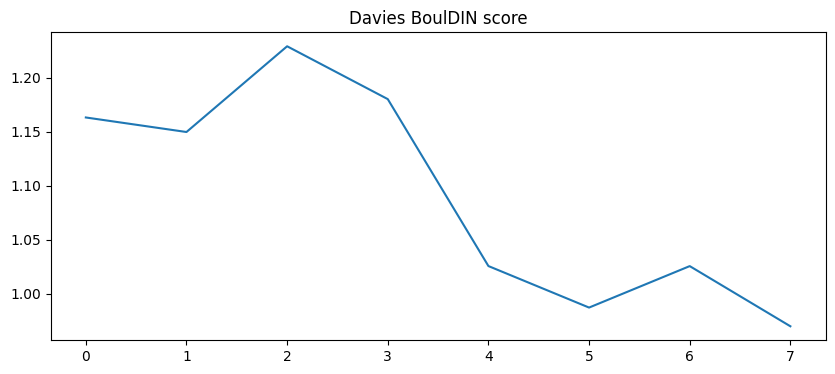

In [175]:
plt.plot(davies_bouldin)
plt.title("Davies BoulDIN score")
plt.show()

Due to the distortion and the silhouette score, we select a kernel of four clusters.

In [176]:
df["label"] = labels_save[4]

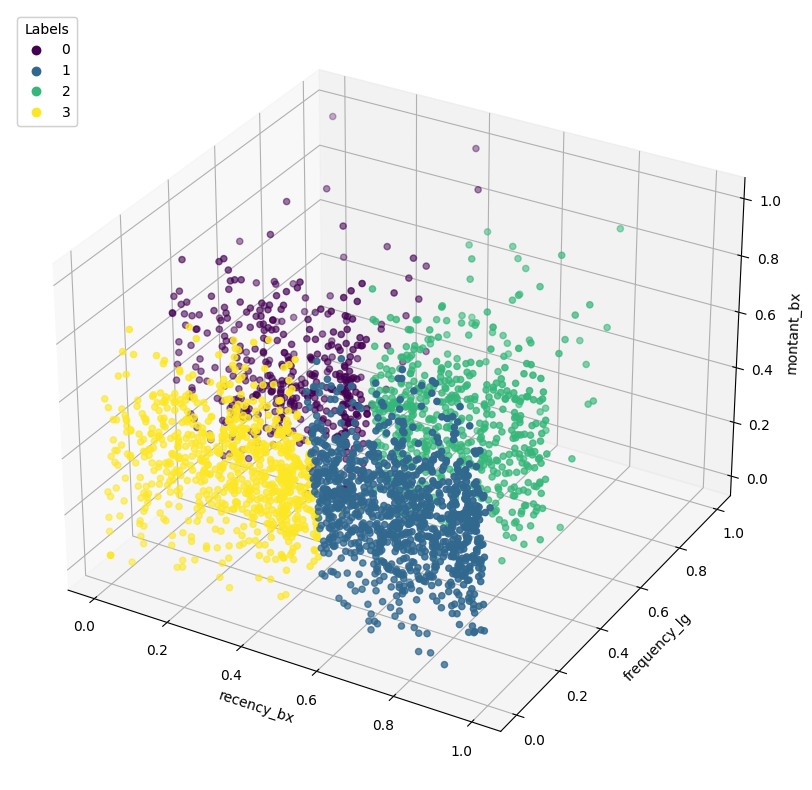

In [177]:
plt.rcdefaults()
x, y, z = col
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(df[x], df[y], df[z], c=df["label"])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
# Create a legend with the labels for the different values of "label"
legend = ax.legend(*sc.legend_elements(), title="Labels", loc="upper left")
ax.add_artist(legend)
plt.show()

In [178]:
means = df.groupby('label').mean()
means = means.reset_index()
means

,label,recency_bx,frequency_lg,montant_bx
0,0,0.316562,0.310801,0.595403
1,1,0.770096,0.000261,0.511559
2,2,0.745179,0.308822,0.595143
3,3,0.338572,0.000778,0.485079


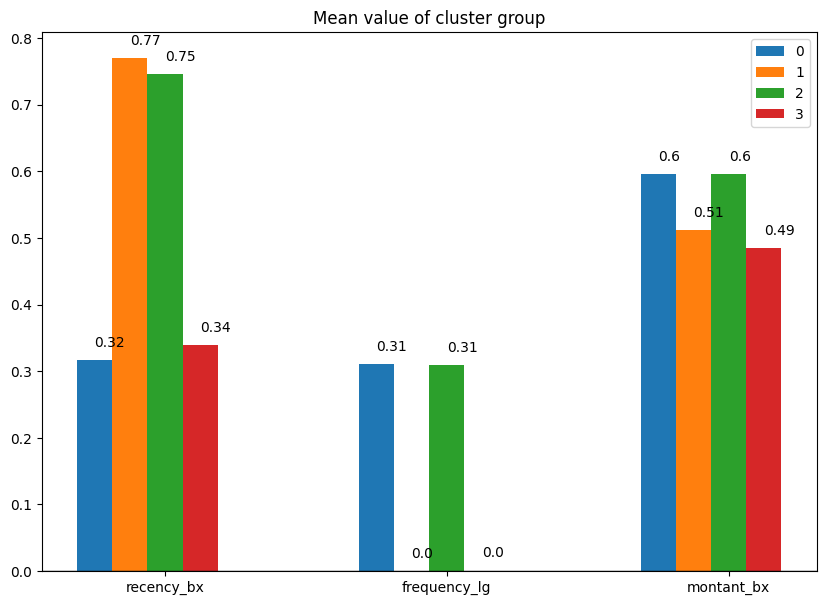

In [179]:
means = df.groupby('label').mean()
means = means.reset_index()
barWidth = 0.25
test = np.array([2,4,6]) 
N = means.shape[0]
%pycodestyle_off
plt.figure(figsize =(10, 7))
for i in range(N) : 
    inv = means.iloc[i]
    plt.bar(test + i * barWidth, inv[col], label= int(inv['label']), width=barWidth)
    for k in range(3): 
        offset = 0.02 if inv[col][k] >= 0 else -0.02
        plt.text(test[k] + i * barWidth, inv[col][k] + offset, str(round(inv[col][k],2)))
plt.title('Mean value of cluster group')
# For your case
plt.axhline(y=0,linewidth=1, color='k')
plt.xticks(test + (N*barWidth )/2,col)
plt.legend()
plt.show()
%pycodestyle_on

- group 0 : MMH : bought recently and frequently for high values
- group 1 : HLH : bought recently and not frequently for high values 
- group 2 : HMH : bought recently and frequently for high values
- group 1 : MLH : bought recently and not frequently for high values


So here, groups are mainly characterize by the recency and the frequency of there orders. 

We can look at it further in the following boxplot : 

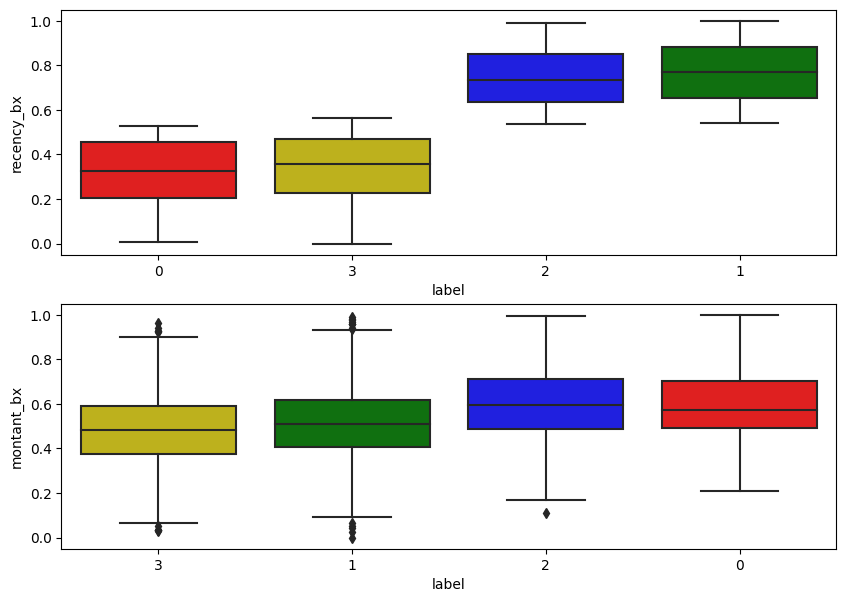

In [180]:
my_order = df.groupby('label').mean().sort_values('montant_bx').index
my_order1 = df.groupby('label').mean().sort_values('recency_bx').index
label_colors = {0: 'red', 1: 'green', 2: 'blue',
                3: 'y', 4: 'm', 5: '#8c564b', 6: '#e377c2'}

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
sns.boxplot(data=df, x='label', order=my_order1,
            y=col[0], ax=axs[0], palette=label_colors)
sns.boxplot(data=df, x='label', order=my_order,
            y=col[2], ax=axs[1], palette=label_colors)
plt.show()

For instance here, the group 0 is interesting,  it concerns clients that order for high monetary value but did not order recently.

The marketing group can employ specific campaigns to renew these clients such as sending them vouchers. 

In [181]:
davies_bouldin_score_dt["RFM"] = davies_bouldin_score(df[col], df['label'])
silhouette_score_dt["RFM"] = metrics.silhouette_score(df[col], df['label'])

## Add other features
Let's include in our clustering more costumer related variables : 
- the distance from the capital 
- the mean review score
- the mean number of payments installments, meaning if the costumer spilt the payment into multiple times 

In [182]:
clientsPlus = pd.read_csv("clients+.csv", low_memory=False)

In [183]:
clientsPlus.describe()

,recency_bx,frequency_lg,montant_bx,costumer_dist_from_capital_lg,review_score,payment_installments_bx
count,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000
mean,0.584490,0.109907,0.534318,0.600806,0.787634,0.352742
std,0.251239,0.158368,0.170289,0.314979,0.280445,0.314745
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.401145,0.000000,0.420880,0.434326,0.625000,0.000000
50%,0.611274,0.000000,0.532729,0.745240,0.916667,0.373792
75%,0.788470,0.278943,0.643870,0.812629,1.000000,0.638611
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.962008


In [184]:
clientsPlus.set_index("customer_unique_id")
col = clientsPlus.columns[1:]
col

Index(['recency_bx', 'frequency_lg', 'montant_bx',
       'costumer_dist_from_capital_lg', 'review_score',
       'payment_installments_bx'],
      dtype='object')

Let's choose the number of cluster needed : 

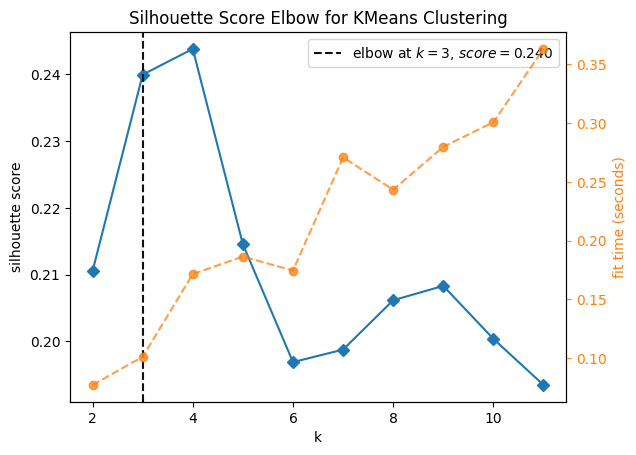

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

6:1: W391 blank line at end of file


In [185]:
df = clientsPlus[col]
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12), metric='silhouette')
visualizer.fit(df)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data


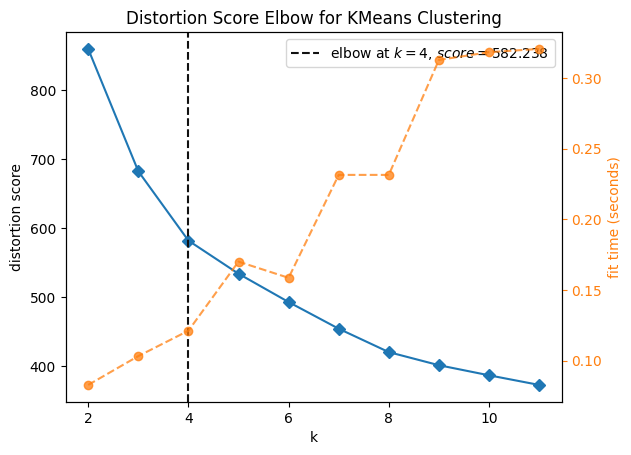

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [186]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(df)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Here we also consider four different clusters, taking into account both metrics. 

In [187]:
labels_save = pd.DataFrame()
silhouette_score_vec = []
inertia_vec = []
for k in range(2, 10):
    inertia, label, centroids_df, silhouette_score = run_kmeans(df.values, k)
    labels_save[k] = label
    silhouette_score_vec.append(silhouette_score)
    inertia_vec.append(inertia)

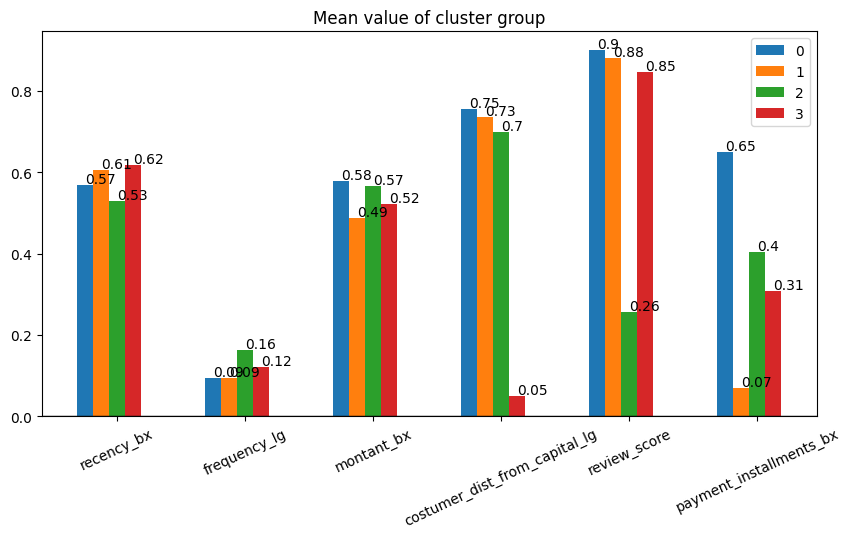

In [188]:
df_label = df
df_label['label'] = labels_save[4]
means = df_label.groupby('label').mean()
means = means.reset_index()
barWidth = 0.25
test = np.array([2,4,6,8,10,12]) 
N = means.shape[0]
%pycodestyle_off
plt.figure(figsize =(10, 5))
for i in range(N) : 
    inv = means.iloc[i]
    plt.bar(test + i * barWidth, inv[col], label= int(inv['label']), width=barWidth)
    for k in range(6): 
        offset = 0.005 if inv[col][k] >= 0 else -0.005
        plt.text(test[k] + i * barWidth, inv[col][k] + offset, str(round(inv[col][k],2)))
plt.title('Mean value of cluster group')
# For your case
plt.axhline(y=0,linewidth=1, color='k')
plt.xticks(test + (N*barWidth )/2,col,rotation = 25)
plt.legend()
plt.show()
%pycodestyle_on

Let's analyze this clustering : 

- group 0 : far costumer paying multiple times
- group 1 : far costumer paying once
- group 2 : unhappy costumer
- group 3 : close to the capital and unsatisfied costumers


In [189]:
davies_bouldin_score_dt["RFMPLUS"] = \
    davies_bouldin_score(df_label[col], df_label['label'])
silhouette_score_dt["RFMPLUS"] = \
    metrics.silhouette_score(df_label[col], df_label['label'])

## PCA  before clustering : 

In [190]:
pca = PCA(n_components=6)
pca.fit(df[col])
pca.explained_variance_ratio_.cumsum()

array([0.28010126, 0.51384652, 0.71519012, 0.87123019, 0.95568046,
       1.        ])

In [191]:
X_trans = pca.transform(df[col])

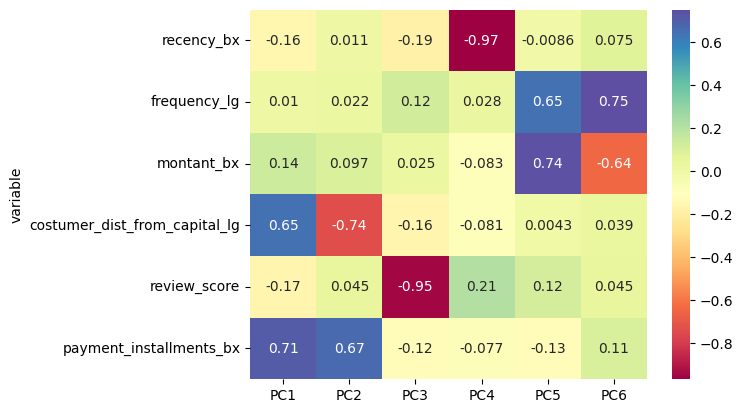

8:47: W291 trailing whitespace


In [192]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = col
loadings_df = loadings_df.set_index('variable')
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.rcParams["figure.figsize"] = [10.00, 4.00] 
plt.show()

This is really interesting here, as the first two main components are carried by the same two variables : 
the distance from the capital and the payment installments. 

In [193]:
pca = PCA(n_components=6)
pca.fit(df[col])
X_trans = pca.transform(df[col])

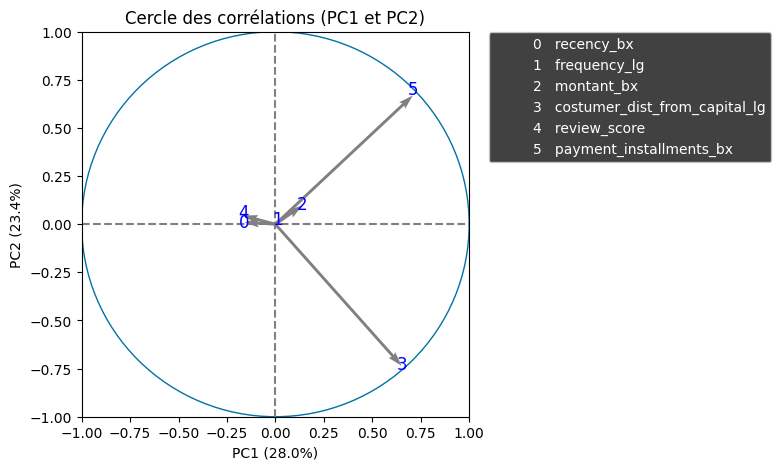

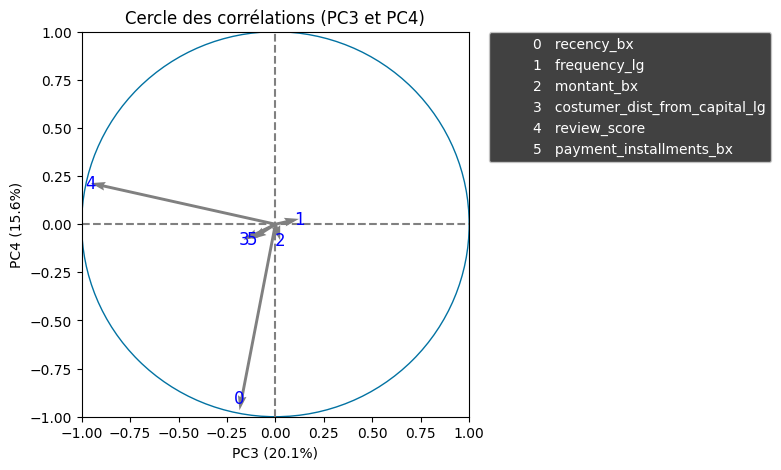

In [194]:
display_circles(pca.components_, 6, pca, [(0, 1), (2, 3)], labels=col)

- 'PC1' : costumer that will pay in multiple time, close to the capital
- 'PC2  : costumer that will pay in multiple time, far from the capital
- 'PC3' : Unsatisfied costumers

Let's consider these three main components for clustering : 
First, let's choose the number of cluster : 

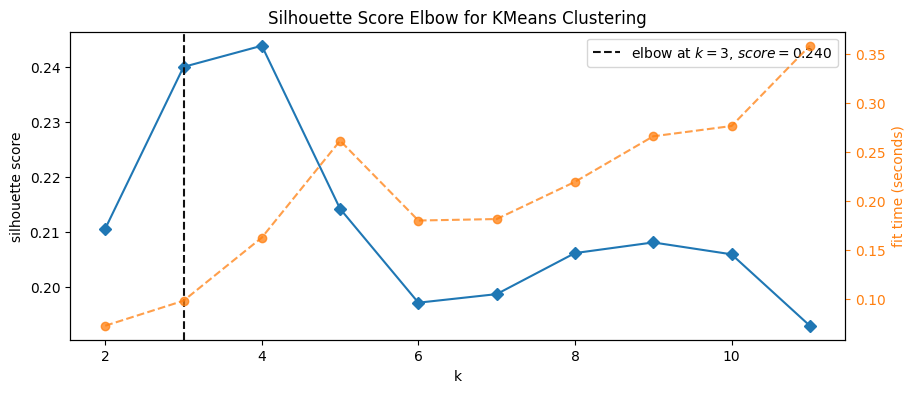

In [195]:

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12), metric='silhouette')
visualizer.fit(X_trans)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()

Here we consider four clusters. 

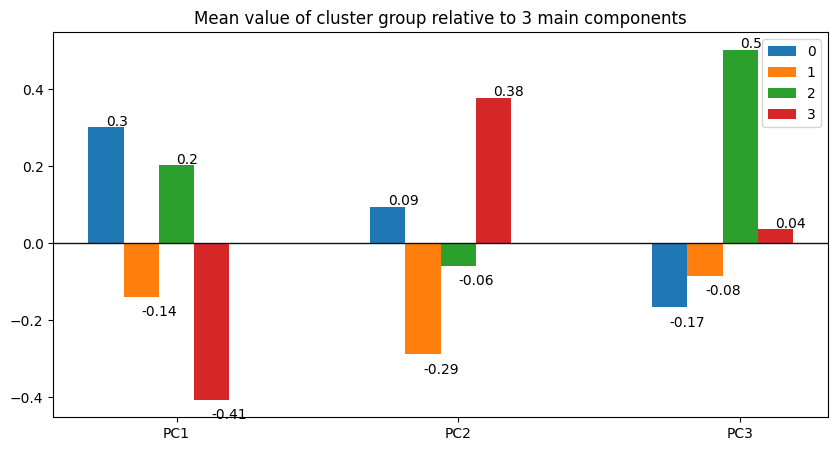

In [196]:
df_pca = pd.DataFrame(X_trans)
inertia, label, centroids_df,silhouette_score = run_kmeans(df_pca.values,4)
df_pca['label'] = label
means = df_pca.groupby('label').mean()
means = means.reset_index()
barWidth = 0.25
test = np.array([2,4,6]) 
N = means.shape[0]
%pycodestyle_off
plt.figure(figsize =(10, 5))
for i in range(N) : 
    inv = means.iloc[i]
    plt.bar(test + i * barWidth, inv[[0,1,2]], label= int(inv['label']), width=barWidth)
    for k in range(3): 
        offset = 0.005 if inv[[0,1,2]][k] >= 0 else -0.05
        plt.text(test[k] + i * barWidth, inv[[0,1,2]][k] + offset, str(round(inv[[0,1,2]][k],2)))
plt.title('Mean value of cluster group relative to 3 main components')
# For your case
plt.axhline(y=0,linewidth=1, color='k')
plt.xticks(test + (N*barWidth )/2,['PC1','PC2','PC3'])
plt.legend()
plt.show()
%pycodestyle_on

The understanding is harder since the PC1 axis are not directly related to only one feature. We can deduce : 
- group 0 : satisfy customers, paying multiple time
- group 1 : costumer living close to the capital. 
- group 2 : unsatisfied costumers and live far from the capital . 
- group 3 : costumer far from  the capital.


In [197]:
df_pca['label'].value_counts()

1    922
0    889
3    545
2    410
Name: label, dtype: int64

There are less costumers in cluster 2 and 3  than in cluster 0 and 1. 

In [198]:
davies_bouldin_score_dt["RFMPLUS_PCA"] = \
    davies_bouldin_score(df_pca[[0, 1, 2]], df_pca['label'])
silhouette_score_dt["RFMPLUS_PCA"] = \
    metrics.silhouette_score(df_pca[[0, 1, 2]], df_pca['label'])

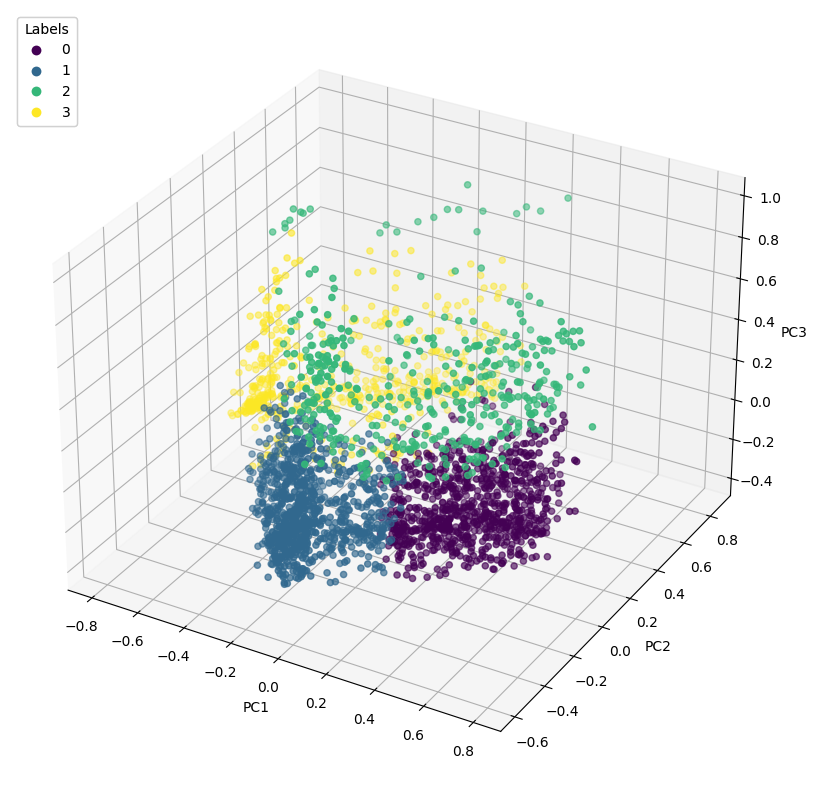

In [199]:
data = pd.DataFrame(X_trans)
inertia, label, centroids_df, silhouette_score = run_kmeans(data.values, 4)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
legend = ax.legend(*sc.legend_elements(), title="Labels", loc="upper left")
ax.add_artist(legend)
ax.scatter(data[0], data[1], data[2], c=label)
ax.set_xlabel(pc_list[0])
ax.set_ylabel(pc_list[1])
ax.set_zlabel(pc_list[2])
plt.show()

# Agglomerative Clustering
Use bottom_up approach : each observation starts its own cluster and clusters are merged successively. The linkage criteria here is the Ward merge strategy, that minimize the variance intra-cluster. 

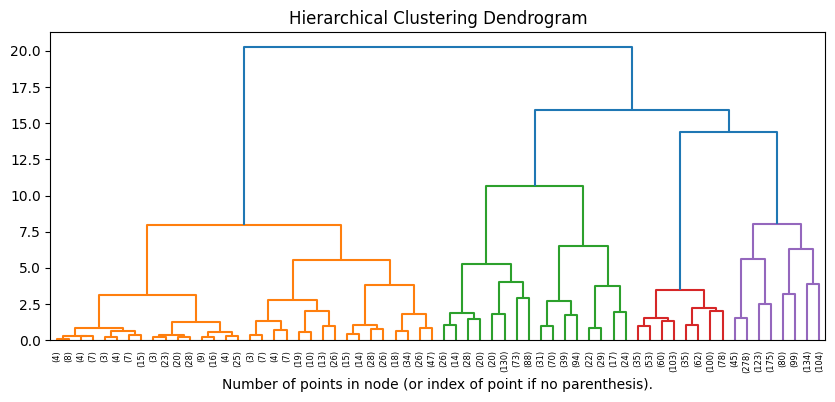

In [200]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
col = [0, 1, 2]
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, linkage='ward')
model = model.fit(df_pca[col])
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

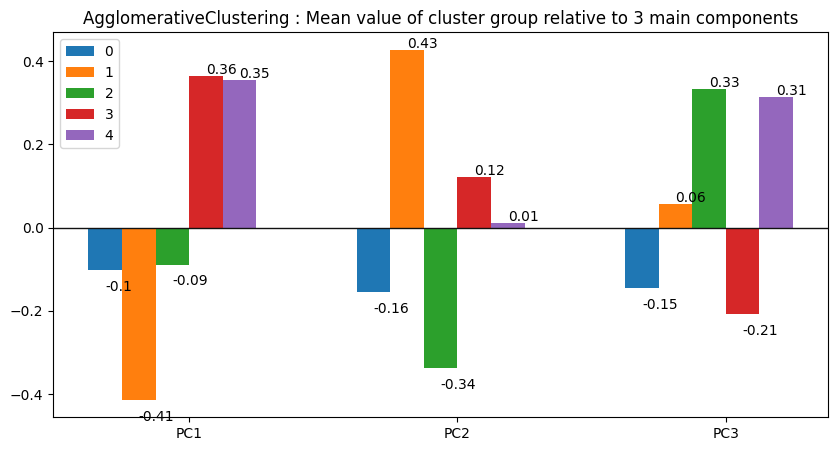

In [201]:
df_pca['label_agglo'] = agglo.labels_
means = df_pca.groupby('label_agglo').mean()
means = means.reset_index()
barWidth = 0.25
test = np.array([2,4,6]) 
N = means.shape[0]
%pycodestyle_off
plt.figure(figsize =(10, 5))
for i in range(N) : 
    inv = means.iloc[i]
    plt.bar(test + i * barWidth, inv[[0,1,2]],
            label= int(inv['label_agglo']),
            width=barWidth)
    for k in range(3): 
        offset = 0.005 if inv[[0,1,2]][k] >= 0 else -0.05
        plt.text(test[k] + i * barWidth,
                 inv[[0,1,2]][k] + offset,
                 str(round(inv[[0,1,2]][k],2)))
plt.title('AgglomerativeClustering : Mean value\
    of cluster group relative to 3 main components')
# For your case
plt.axhline(y=0,linewidth=1, color='k')
plt.xticks(test + (N*barWidth )/2,['PC1','PC2','PC3'])
plt.legend()
plt.show()
%pycodestyle_on

We have now two group that are unsatisfied. The marketing could focus on understanding why these costumer are unsatisfied to improve the user experience.  

In [202]:
davies_bouldin_score_dt["AGGLOMERATIVE"] = \
    davies_bouldin_score(df_pca[[0, 1, 2]], df_pca['label_agglo'])
silhouette_score_dt["AGGLOMERATIVE"] = \
    metrics.silhouette_score(df_pca[[0, 1, 2]], df_pca['label_agglo'])

# DBSCAN

DBSCAN needs to be tuned (hyper-parameters fit), especially for 
- eps : the maximum distance between two samples, this is the most important DBSCAN parameter to choose.
- min_samples : number of point in a neighborhood to be considered as a core point

In [210]:
df = df_pca[[0,1,2]]
eps_range = np.arange(0.01,0.5,0.1)
min_samples_range = np.arange(2,11)
scores = []
param_combinations = []
%pycodestyle_off
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=2)
        dbscan.fit(df.values)
        if len(np.unique(dbscan.labels_) )> 1 :
            score = metrics.silhouette_score(df.values, dbscan.labels_)
        else : 
            score = 0 
        scores.append(score)
        param_combinations.append((eps, min_samples))
        param_combinations.append((eps, min_samples))
%pycodestyle_on        
# Find the combination of hyperparameters with the highest silhouette score
best_idx = np.argmax(scores)
best_eps, best_min_samples = param_combinations[best_idx]

In [211]:
best_eps

0.11

In [212]:
best_min_samples

2

In [206]:
df = df_pca[[0, 1, 2]]
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(df.values)

DBSCAN(eps=0.11, min_samples=2)

C:\Users\Clara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, '2')

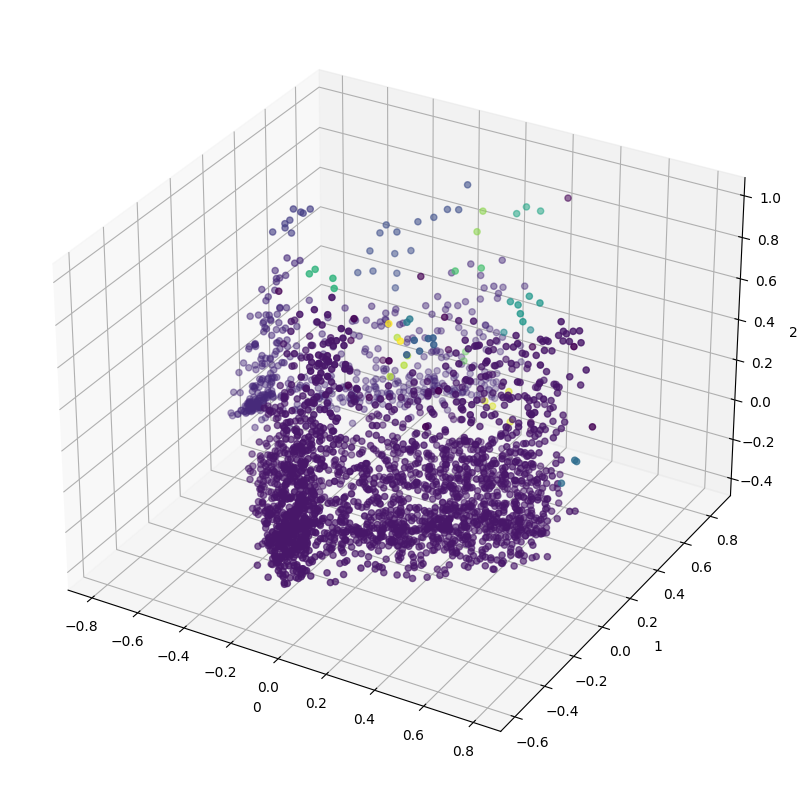

In [207]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(df.values)
df['label'] = dbscan.labels_
df['label'].unique()
x, y, z = [0, 1, 2]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(df[x], df[y], df[z], c=df["label"])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

As DBSCAN works by density and do not consider points that can not be join by density, the cluster size here are extremely small. And not usable by the marketing group. 

In [208]:
davies_bouldin_score_dt["DBSCAN"] = \
    davies_bouldin_score(df.values, dbscan.labels_)
silhouette_score_dt["DBSCAN"] = \
    metrics.silhouette_score(df.values, dbscan.labels_)

# Conclusion 

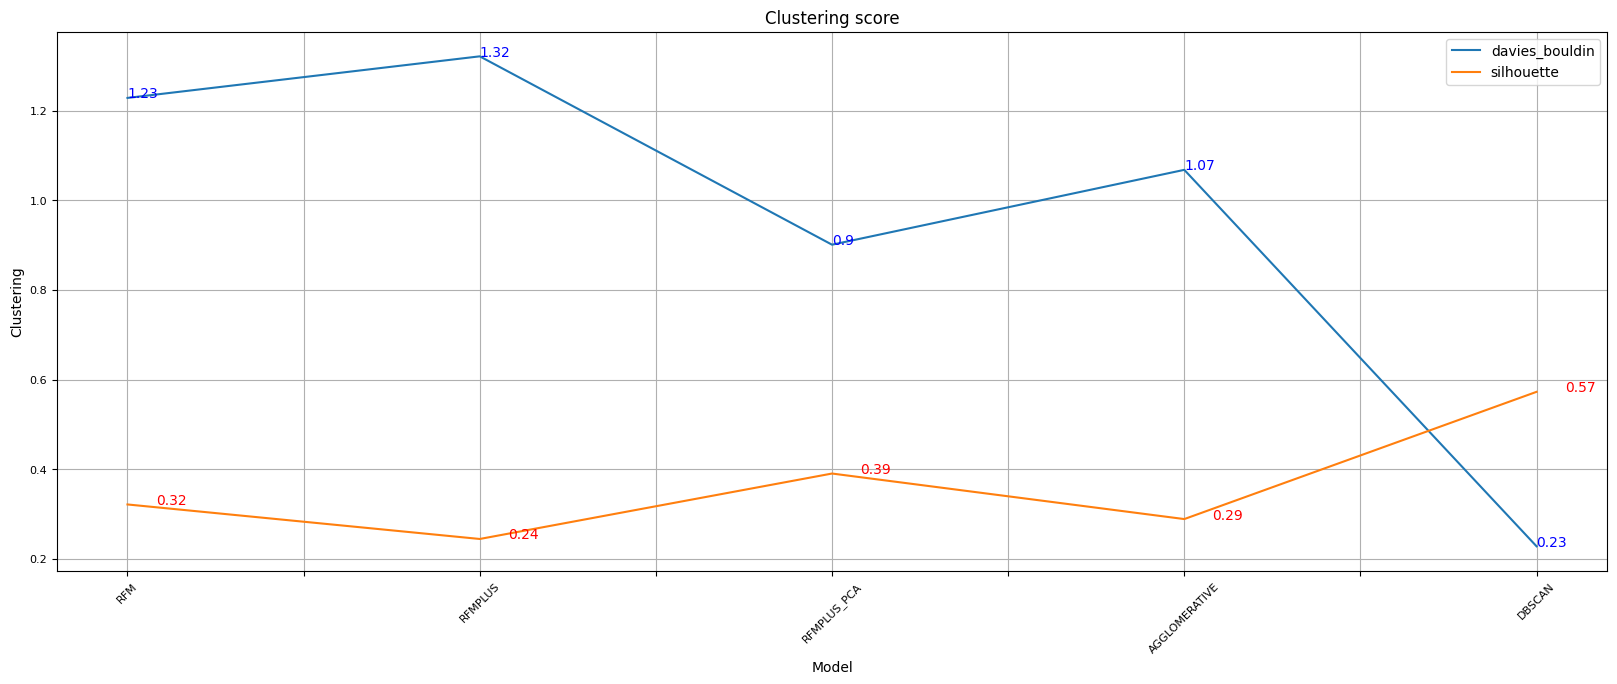

In [209]:
scores_map_test1 = \
    pd.DataFrame(davies_bouldin_score_dt, index=['davies_bouldin']).transpose()
scores_map_test2 = \
    pd.DataFrame(silhouette_score_dt, index=['silhouette']).transpose()
scores_map_both = scores_map_test1.join(scores_map_test2)

fig, ax = plt.subplots(figsize=(20, 7))
scores_map_both.plot(ax=ax, grid=True)
rows, cols = scores_map_both.shape
offset = 0
color = 'blue'
for col in range(cols):
    for i in range(rows):
        ax.annotate('{}'.format(
            round(scores_map_both.iloc[i, col], 2)),
                    xy=(i + offset, scores_map_both.iloc[i, col]),
                    color=color)
    offset = 0.08
    color = 'red'
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Model')
plt.ylabel("Clustering")
plt.title("Clustering score")
plt.show()

By a cluster analysis and the silhouette and Davies-Bouldin coefficients, we select **RFM and added variables + PCA followed by K-means** clustering for our segmentation. 